In [64]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

# Load Data

In [65]:
# Training and testing data directories
train_dir = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/brain_data/Training')
test_dir = os.path.expanduser('~/Desktop/Projects/Brain Tumor Detection/brain_data/Testing')

# Load and shuffle the training data
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the testing data
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

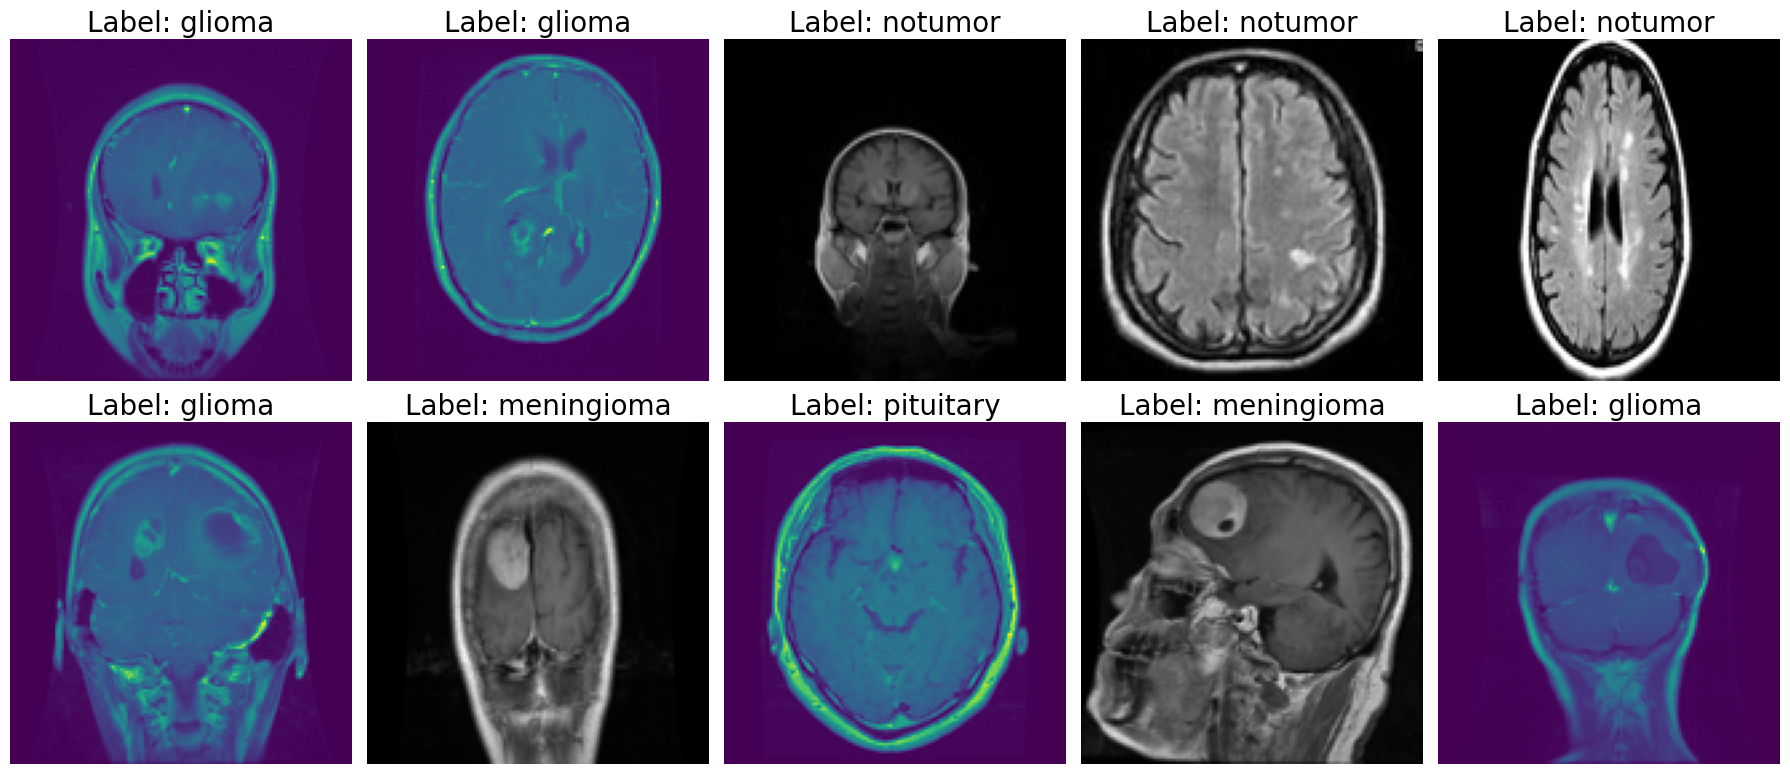

In [66]:
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(train_paths)), 10)
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

# Display images randomized from sample
for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((128, 128))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=20)

plt.tight_layout()
plt.show()

# Image Preprocessing

In [67]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Convert labels to ints
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# Model

In [69]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os

# Model architecture
IMAGE_SIZE = 224

# Load MobileNetV3Large as base model
base_model = MobileNetV3Large(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet',
    pooling=None,
    include_preprocessing=False  # Add this if you're preprocessing your images separately
)

# Freeze all layers of the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers to be trainable
# MobileNetV3 has different architecture than VGG, so we'll unfreeze some later layers
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

# Dense layer with ReLU activation
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 50

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 0.7941 - sparse_categorical_accuracy: 0.7965
Epoch 2/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.0734 - sparse_categorical_accuracy: 0.9734
Epoch 3/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - loss: 0.0301 - sparse_categorical_accuracy: 0.9905
Epoch 4/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9950
Epoch 5/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9967
Epoch 6/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - loss: 0.0121 - sparse_categorical_accuracy: 0.9963
Epoch 7/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - loss: 0.0164 - sparse_categorical_accuracy: 0.9961
Epoch 8/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - loss: 0.0079 - sparse_categorical_accuracy: 0.9987
Epoch 9/50
285/285 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - loss: 0.0038 - sparse_categorical_accuracy: 0.9980
Epoch 10/50
285/285 ━━━━━━━━

# Training Plot

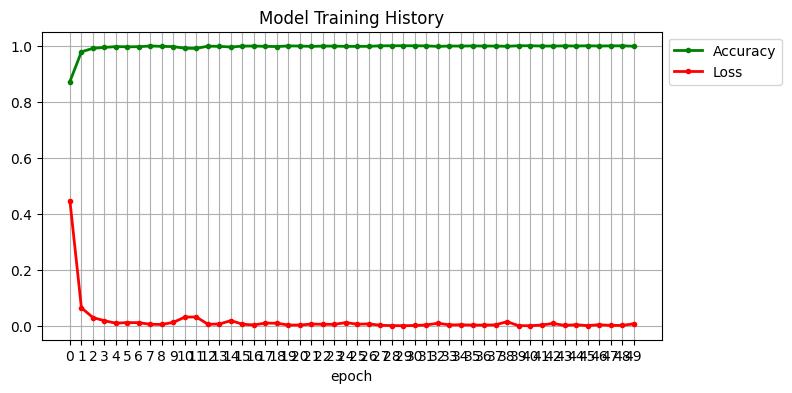

In [72]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Classification

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report (with 4 decimal precision)
print("Classification Report:")
print(classification_report(
    test_labels_encoded,
    np.argmax(test_predictions, axis=1),
    digits=4  # Show all metrics rounded to 4 decimal places
))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9967    0.9967    0.9967       300
           1     0.9975    0.9975    0.9975       405
           2     0.9864    0.9700    0.9782       300
           3     0.9646    0.9804    0.9724       306

    accuracy                         0.9870      1311
   macro avg     0.9863    0.9861    0.9862      1311
weighted avg     0.9871    0.9870    0.9870      1311



# Confusion Matrix

Confusion Matrix:
[[300   0   0   0]
 [  0 404   0   1]
 [  0   0 290  10]
 [  1   1   3 301]]


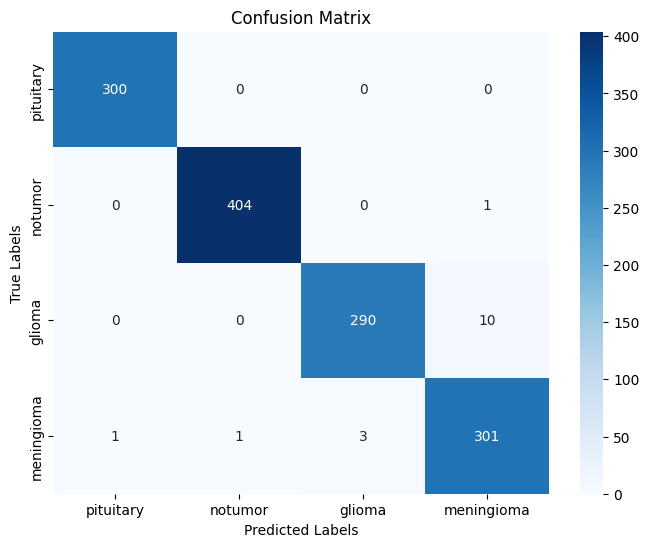

In [73]:
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve

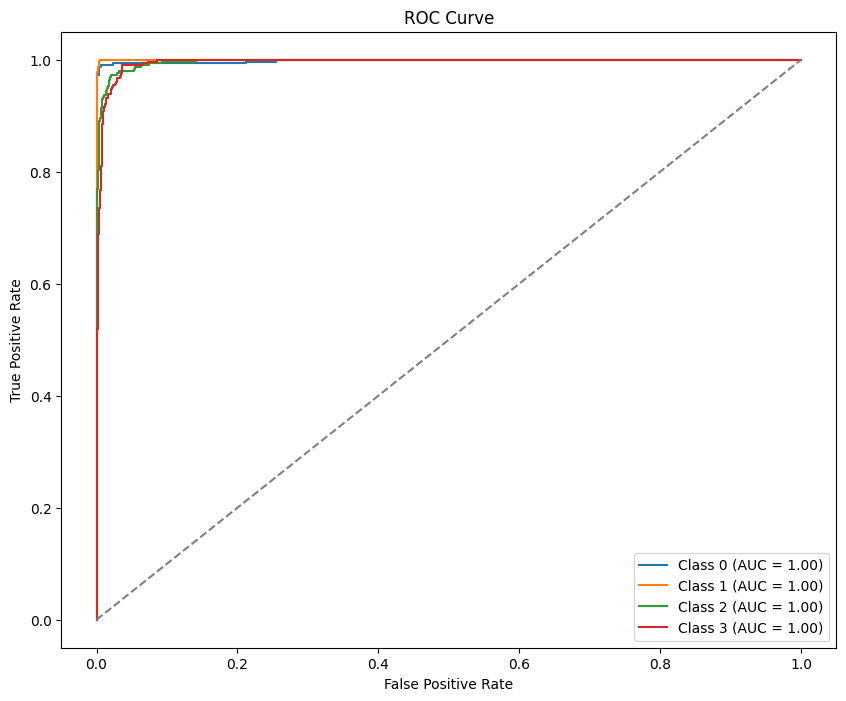

In [62]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()